# Labeling

For each ticker, we want to label the best buy/sell/hold actions (this is the classification label we will train on).

This is the starting logic (before extra cases complicate it):

- iterate over prices for the ticker (over time)
- e.g. prices: 
- for the first record, we will buy 1 share at that price (this becomes our balance)
- for every following record:
    - if the current price is more than the previous price
        - action = "sell"
        - if previous action is "sell", set previous row action to "hold"
    - if the current price is less than the previous price
        - action = "buy"
        - if previous action is "buy", set previous row action to "hold"
    - keep track of cost basis and profit/loss based on current liquid and realized values

This will iterate like so over the following price list:

- prices = [20, 21, 22, 18, 17, 16, 17]
- actions = 
- buy
- buy, sell
- buy, hold, sell
- buy, hold, sell, buy
- buy, hold, sell, hold, buy
- buy, hold, sell, hold, hold, buy
- buy, hold, sell, hold, hold, buy, sell (final action list)
- $3 profit

In [244]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [245]:
import pandas as pd
import os
import matplotlib.pylab as plt
# import logging
# logging.basicConfig()
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger('foo').debug('bah')
# logging.getLogger().setLevel(logging.DEBUG) 
# logging.getLogger('foo').debug('bah')

In [246]:
def label_actions(df, verbose=False, col='close', significance=0.10):
    df['buy'] = 0
    df['sell'] = 0
    df['hold'] = 0
    df['action'] = 'hold'
    holding=0
    cost_basis=0
    liquid=0
    profit=0
    buys=0
    sells=0
    last_basis=0
    last_row_i=-1
    last_quantity_sold=0
    last_profit=0
    first_row_i=0
    for i, row in df.iterrows():
        if last_row_i==-1:
            # first record: buy one
            buys=1
            holding=1
            cost_basis = row[col]
            df.set_value(i,'action','buy')
            first_row_i = i
        else:
            last_row = df.loc[last_row_i]
            last_sell = last_row.action=='sell'
            last_buy = last_row.action=='buy'
            price_same = row[col] == last_row[col]
            # TODO: also ensure price has changed at least 1%-5% or .05...or something
            # >= to catch moving the sell signal over a plateau 
            if (row[col] >= cost_basis) & ((row[col] > last_row[col]) | (price_same & last_sell)):
                df.set_value(i,'action','sell')
                if last_row.action == "sell":
                    df.set_value(last_row_i,'action','hold')
                    # remove the recorded profit from the last sale
                    profit -= last_profit
                    # add the profit from selling at this price
                    last_profit=(last_quantity_sold * (row[col] - last_basis))
                    profit += last_profit
                else:
#                     significant = (row[col] - last_row[col] > significance)
#                     if significant:
                        if holding == 0:
                           print('!!!!!!!!!!!!Anomaly!!') 
                        last_quantity_sold=holding
                        last_profit=(holding * (row[col] - cost_basis))
                        profit += last_profit
                        sells += 1
                        last_basis=cost_basis
                        holding = 0
                        cost_basis = 0
            elif ((cost_basis==0) | (row[col] <= cost_basis)) & ((row[col] < last_row[col]) | (price_same & last_buy)):
                df.set_value(i,'action','buy')
                if (last_row.action == "buy"):
                    
                    # update the first entry to a sell if the price went down (significantly?)
                    if (last_row_i == first_row_i) & (not price_same):
                        df.set_value(last_row_i,'action','sell')
                    else:
                        df.set_value(last_row_i,'action','hold')
                    # adjust the recorded cost-basis to the new cost
                    last_held = holding-1
                    if last_held==0:
                        cost_basis = row[col]
                    else:
                        cost_basis = ((last_basis * last_held) + row[col]) / (holding)
                    last_basis=cost_basis
                else:
#                     significant = (last_row[col] - row[col] > significance)
#                     if(significant):
                        last_basis = cost_basis
                        if holding==0:
                            cost_basis = row[col]
                        else:
                            cost_basis = ((cost_basis * holding) + row[col]) / (holding+1)
                        holding += 1
                        buys += 1
                    
        if verbose:
            print(df.get_value(i,'action'), "\tclose: {0:.2f}".format(row[col]), '\tholding:', holding, "\tbasis: {0:.2f}".format(cost_basis),"\tlast basis: {0:.2f}".format(last_basis), "\tprofit: {0:.4f}".format(profit))
#             print(row['4h_rsi'], row['4h_stochrsi'])
        last_row_i = i
        liquid = (row[col]*holding) - (cost_basis*holding) + profit

    print("holding:", holding, "\tbasis:", "{0:.2f}".format(cost_basis), "\trealized:", "{0:.2f}".format(profit), "\tliquid:","{0:.2f}".format(liquid), "\tbuys:", buys, "\tsells:",sells)
    # correct the single word label into a binary multi-label
    df['buy'] = df['action']=='buy'
    df['sell'] = df['action']=='sell'
    df['hold'] = df['action']=='hold'
    df['buy'] = df['buy'].astype(int)
    df['sell'] = df['sell'].astype(int)
    df['hold'] = df['hold'].astype(int)
    df.drop(['action'], axis=1, inplace=True)
    return df

In [247]:
indicators=['price','STOCH','STOCHRSI','RSI','SMA','EMA','MACD','ADX','CCI','AROON','BBANDS','AD','OBV']

In [248]:
dfs={}
for ind in indicators:
    dfs[ind] = pd.read_csv('timeseries/GOOG.daily.'+ind+'.csv',index_col=None)
    if 'time' in dfs[ind]:
#         print(dfs[ind].time.str.split(" ").str.get(0))
        dfs[ind]['timestamp'] = dfs[ind]['time'].replace(regex=r'\s.+$', value='')
#         dfs[ind].timestamp = dfs[ind].time.str.split().str.get(0)
        dfs[ind].drop('time', axis=1, inplace=True)
    dfs[ind].timestamp = pd.to_datetime(dfs[ind].timestamp)
    dfs[ind].set_index('timestamp', inplace=True)
    print(ind,dfs[ind].head(2))

price               open    high      low   close   volume
timestamp                                           
2018-10-26  112.84  114.14  112.101  113.19  7971182
2018-10-25  112.62  114.69  112.118  114.16  7405276
STOCH               SlowD    SlowK
timestamp                   
2018-10-26  31.9964  18.4044
2018-10-25  51.3091  31.9178
STOCHRSI               FastD    FastK
timestamp                   
2018-10-26  15.6720  15.7513
2018-10-25  24.4191  31.2647
RSI                 RSI
timestamp          
2018-10-26  46.7418
2018-10-25  48.8361
SMA                 SMA
timestamp          
2018-10-26  115.632
2018-10-25  115.634
EMA                  EMA
timestamp           
2018-10-26  114.8765
2018-10-25  115.3712
MACD              MACD  MACD_Hist  MACD_Signal
timestamp                                
2018-10-26  0.378    -0.4125       0.7905
2018-10-25  0.632    -0.2616       0.8936
ADX                 ADX
timestamp          
2018-10-26  23.3609
2018-10-25  23.1881
CCI                 CC

In [249]:
df = pd.concat(dfs, axis=1,verify_integrity=True,join="inner")
df.columns = df.columns.get_level_values(1)

df.head(5)

,Chaikin A/D,ADX,Aroon Down,Aroon Up,Real Lower Band,Real Middle Band,Real Upper Band,CCI,EMA,MACD,...,SMA,SlowD,SlowK,FastD,FastK,open,high,low,close,volume
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-26,1.970746e+09,23.3609,45.0,80.0,107.1967,115.028,122.8593,-95.0702,114.8765,0.3780,...,115.632,31.9964,18.4044,15.6720,15.7513,112.840,114.14,112.101,113.19,7971182
2018-10-25,1.970956e+09,23.1881,50.0,85.0,107.7240,116.158,124.5920,-82.8334,115.3712,0.6320,...,115.634,51.3091,31.9178,24.4191,31.2647,112.620,114.69,112.118,114.16,7405276
2018-10-24,1.966603e+09,22.9960,55.0,90.0,108.6576,116.562,124.4664,-109.8036,115.6404,0.8035,...,115.333,68.9649,45.6671,35.7966,0.0000,117.060,117.06,111.250,111.61,11630540
2018-10-23,1.976792e+09,22.7826,60.0,95.0,114.8463,117.666,120.4857,71.0014,116.5360,1.2703,...,115.458,84.5897,76.3424,69.1300,41.9925,116.945,118.49,115.410,117.85,8607373
2018-10-22,1.971762e+09,24.8113,65.0,100.0,114.0448,117.334,120.6232,138.9946,116.2441,1.2122,...,115.362,88.7292,84.8851,79.8193,65.3974,119.050,119.69,117.720,118.27,8406370


In [250]:
df.columns

Index(['Chaikin A/D', 'ADX', 'Aroon Down', 'Aroon Up', 'Real Lower Band',
       'Real Middle Band', 'Real Upper Band', 'CCI', 'EMA', 'MACD',
       'MACD_Hist', 'MACD_Signal', 'OBV', 'RSI', 'SMA', 'SlowD', 'SlowK',
       'FastD', 'FastK', 'open', 'high', 'low', 'close', 'volume'],
      dtype='object')

In [251]:
# drop NaN columns (where we didn't have RSI, Stoch, etc for the price, or vice-versa)
df.dropna(inplace=True)
# drop the newest record (partial day data if intraday)
# df = df.iloc[1:]
# reverse order to oldest -> newest
# df = df.iloc[::-1]
# drop the oldest record (comparisons to previous will be maxed-out)
# df = df.iloc[1:]
df = df.sort_index()
df.head(5)

,Chaikin A/D,ADX,Aroon Down,Aroon Up,Real Lower Band,Real Middle Band,Real Upper Band,CCI,EMA,MACD,...,SMA,SlowD,SlowK,FastD,FastK,open,high,low,close,volume
timestamp,,,,,,,,,,,,,,,,,,,,,
1998-07-10,9.495330e+06,25.8160,100.0,0.0,10.0417,93.966,177.8903,-654.2586,95.9199,-7.1406,...,101.133,58.8071,60.4938,66.6667,0.0000,37.25,38.50,36.50,38.13,5284767
1998-07-13,2.013191e+07,31.1740,95.0,0.0,-22.1109,80.682,183.4749,-329.7123,85.6399,-11.2952,...,94.021,55.1942,33.3203,34.3784,3.1353,39.00,39.56,38.38,39.38,15306300
1998-07-14,1.766289e+07,35.8263,90.0,10.0,-36.3506,67.338,171.0266,-218.4971,77.3199,-14.3816,...,86.689,32.4418,3.5113,2.5317,4.4598,39.81,40.25,39.63,39.88,12756600
1998-07-15,1.190596e+07,40.0282,85.0,5.0,-32.6325,53.554,139.7405,-165.0795,70.4217,-16.6758,...,80.117,13.6331,4.0676,3.9380,4.2190,40.06,40.31,39.19,39.38,8713200
1998-07-16,2.014169e+07,43.8513,80.0,0.0,37.4755,39.216,40.9565,-133.6465,64.7651,-18.2887,...,73.418,11.6498,27.3704,34.1568,93.7918,38.44,39.44,38.06,39.31,10147600


In [252]:
# export truth
df.to_csv('./GOOG_joined.csv', header=None, index=None)

In [253]:
# testing
df_labeled = label_actions(df, col='close', verbose=False)

holding: 1 	basis: 113.19 	realized: 1394.40 	liquid: 1394.40 	buys: 1282 	sells: 1281


In [254]:
df_labeled.head(3)

,Chaikin A/D,ADX,Aroon Down,Aroon Up,Real Lower Band,Real Middle Band,Real Upper Band,CCI,EMA,MACD,...,FastD,FastK,open,high,low,close,volume,buy,sell,hold
timestamp,,,,,,,,,,,,,,,,,,,,,
1998-07-10,9.495330e+06,25.8160,100.0,0.0,10.0417,93.966,177.8903,-654.2586,95.9199,-7.1406,...,66.6667,0.0000,37.25,38.50,36.50,38.13,5284767,1,0,0
1998-07-13,2.013191e+07,31.1740,95.0,0.0,-22.1109,80.682,183.4749,-329.7123,85.6399,-11.2952,...,34.3784,3.1353,39.00,39.56,38.38,39.38,15306300,0,0,1
1998-07-14,1.766289e+07,35.8263,90.0,10.0,-36.3506,67.338,171.0266,-218.4971,77.3199,-14.3816,...,2.5317,4.4598,39.81,40.25,39.63,39.88,12756600,0,1,0


<IPython.core.display.Javascript object>


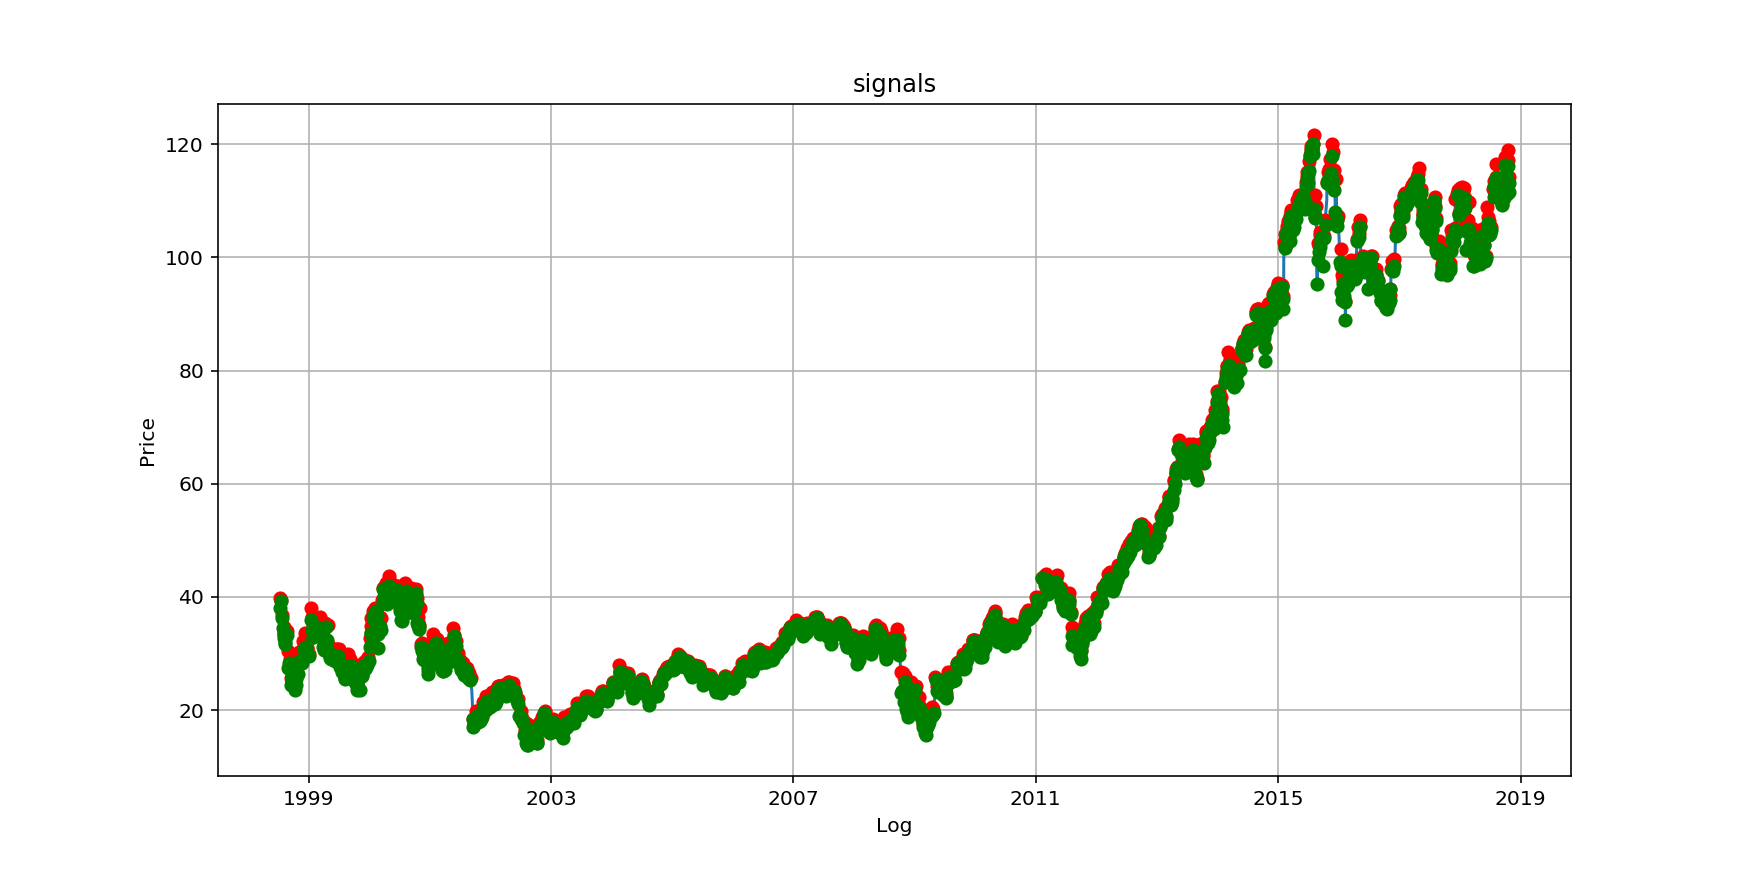

In [255]:
%matplotlib notebook

df_temp = df_labeled

plt.figure(1, figsize=(12, 6), dpi=80)
plt.title('signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(df_temp.close)
plt.plot(df_temp[df_temp.sell==1].close, 'ro', label='sell')
plt.plot(df_temp[df_temp.buy==1].close, 'go', label='buy')
plt.grid(True)
plt.show()

In [256]:
# export truth
df_labeled.to_csv('./labeled_GOOG.csv')